In [9]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')

from rl.algs.dqn import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# GridWorld (debugging)
from rl.algs import experiment
from rl.algs import model
from rl.algs.envs import grid_world

BATCH_SIZE = 32
TRAIN_START_STEP = 3 * BATCH_SIZE
NUM_TRAIN_STEPS = 10000 # 17
REPLAY_SIZE = 100000
TARGET_NETWORK_UPDATE_FREQ = 500


env = environment.GridWorldWrapped(grid_shape=(4, 4, 1))
conv_specs = {
  model.ConvSpec(4, 1, 32),
}
fc_specs = (64,)
model_params = {
  'conv_specs': conv_specs,
  'fc_specs': fc_specs,
}

EPS_DECAY = util.Schedule((0, TRAIN_START_STEP, NUM_TRAIN_STEPS / 1, NUM_TRAIN_STEPS),
                          (1, 1, 0.0, 0.0))
EPS_RANDOM = util.Schedule((0,), (1.0,))
policy_params = {
    'lr': 0.005,
    'eps_sched': EPS_DECAY,  # TODO: change
    'target_update_freq': TARGET_NETWORK_UPDATE_FREQ,
}
exp = experiment.Experiment(env, model.QNetwork, model_params,
                            Dqn, policy_params)

print(exp.policy.model)

rb = ReplayBuffer(REPLAY_SIZE)
for step in range(TRAIN_START_STEP):
  sars = env.step(exp.policy.get_action)
  rb.add(sars)

eps_rew = 0
for step in range(TRAIN_START_STEP, NUM_TRAIN_STEPS):
  sars = env.step(exp.policy.get_action)
  rb.add(sars)
    
  experience_batch = rb.sample(BATCH_SIZE)
  m = exp.policy.update(experience_batch)
  
  eps_rew += sars.r
  if sars.s1 is None:
    m['r_per_eps'] = eps_rew
    eps_rew = 0
  if step % 100 == 0 or sars.s1 is None:
    for k, v in m.items():
      exp.plt.add_data(k, step, v)
      
# Expect about r_per_eps=-50 in pure random agent.

(1, 1, 32)
QNetwork(
  (convs): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [11]:
opt = grid_world.GridWorld((4, 4)).optimal_expected_reward()
print(f'optimal expected r: {opt}')

optimal expected r: 1.6666666666666665


In [37]:
env.show_model_policy(exp.policy.model)

[[ 0.          0.00459319 -0.93927145 -1.70513606]
 [-0.07293212 -0.8611213  -1.76077914 -2.87749481]
 [-0.86544073 -1.88984895 -2.81150746 -3.85319376]
 [-1.9476409  -2.9053762  -3.51383066 -4.31065369]]
[['⟲' '←' '←' '←']
 ['↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '←']
 ['↑' '↑' '↑' '↓']]
[[ 0.05699685  0.         -0.02683014 -1.06846642]
 [-0.81819499  0.11112297 -0.79165423 -1.81324887]
 [-1.87141514 -0.93451715 -1.75177217 -2.85440207]
 [-2.94600296 -2.02592707 -2.73663783 -3.6263504 ]]
[['→' '⟲' '←' '←']
 ['→' '↑' '←' '←']
 ['↑' '↑' '↑' '←']
 ['↑' '↑' '↑' '↑']]
[[-1.00354743 -0.03162104  0.          0.05031908]
 [-1.86413097 -0.80993354  0.09551504 -0.93800461]
 [-2.79857254 -1.92101598 -1.05296493 -1.94411707]
 [-3.63925099 -2.89192867 -2.1466794  -3.01724148]]
[['→' '→' '⟲' '←']
 ['↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑']
 ['↑' '↑' '↑' '↑']]
[[-1.65495479 -0.79342598  0.03252473  0.        ]
 [-2.57044339 -1.59389126 -0.89238834 -0.03041527]
 [-3.41909337 -2.48572683 -1.86717129 -0.99387527]
 

In [38]:
# Debug the action-value function for a given state.
s = [[0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 2, 0]]
s = np.expand_dims(np.expand_dims(s, 0), -1)
print(exp.policy.model(util.to_variable(s)))
print(exp.policy.target_model(util.to_variable(s)))

Variable containing:
-2.1745 -1.8925 -0.0580 -1.6959
[torch.cuda.FloatTensor of size 1x4 (GPU 0)]

Variable containing:
-2.0959 -2.1576 -0.1639 -1.9269
[torch.cuda.FloatTensor of size 1x4 (GPU 0)]



In [39]:
# Examine the replay buffer.
terminals = rb.filter_by(sars_filter(r=0))
print(len(terminals))

# action-value at 's' was wrong. Search the replay buffer for occurrences of
# the correct transition. It's likely missing, which led the NN to overfit
# on missing data.
trans_s = rb.filter_by(sars_filter(s=s))
trans_s_a = rb.filter_by(sars_filter(s=s,a=2))
print(f'Num with (s): {len(trans_s)}. Num with (s, a): {len(trans_s_a)}')


1701
Num with (s): 65. Num with (s, a): 43


In [35]:
env.visualize(exp.policy, steps=20)

array([[0, 0],
       [1, 0]])
array([[0, 0],
       [1, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])
array([[1, 0],
       [0, 0]])


In [21]:
env = environment.AtariEnvironment('Pong')
REPLAY_SIZE = 1000
cached_rb = ReplayBuffer(REPLAY_SIZE)
for step in range(REPLAY_SIZE):
  cached_rb.add(env.step(lambda _: np.random.randint(env.acs_dim, size=(1,))))

rb = copy.deepcopy(cached_rb)

(84, 84, 4)
(84, 84, 4) 6


In [156]:
# Train the DQN

from rl.algs import experiment

BATCH_SIZE = 32
TRAIN_START_STEP = 100
NUM_TRAIN_STEPS = 500000
REPLAY_SIZE = 40000
TARGET_NETWORK_UPDATE_FREQ = 1000


env = environment.AtariEnvironment('Pong')
model_params = {
  'conv_specs': model.DQN_CONV_SPECS,
  'fc_specs': model.DQN_FC_SPECS,
}
policy_params = {
    'lr': 0.005,
    'eps_sched': util.Schedule((0, TRAIN_START_STEP, NUM_TRAIN_STEPS),
                               (1, 1, 0.1)),
    'target_update_freq': TARGET_NETWORK_UPDATE_FREQ,
}
exp = experiment.Experiment(env, model.QNetwork, model_params,
                            Dqn, policy_params)

print(exp.policy.model)

rb = ReplayBuffer(REPLAY_SIZE)
for step in range(TRAIN_START_STEP):
  sars = env.step(exp.policy.get_action)
  rb.add(sars)
#rb = copy.deepcopy(cached_rb)

eps_rew = 0
for step in range(TRAIN_START_STEP, NUM_TRAIN_STEPS):
  sars = env.step(exp.policy.get_action)
  rb.add(sars)
    
  experience_batch = rb.sample(BATCH_SIZE)
  m = exp.policy.update(experience_batch)
  
  eps_rew += sars.r
  if sars.s1 is None:
    m['r_per_eps'] = eps_rew
    eps_rew = 0
  if step % 100 == 0 or sars.s1 is None:
    for k, v in m.items():
      exp.plt.add_data(k, step, v)

(84, 84, 4)
(84, 84, 4) 6
(7, 7, 64)
QNetwork(
  (convs): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


KeyboardInterrupt: 

In [5]:
env.visualize(exp.policy, steps=600, sleep_ms=0.010)

[0 2 4 3 1]


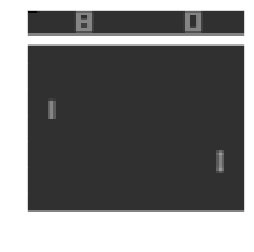

In [41]:
print(np.random.choice(5, 5, replace=False))
def show(sars):
  pyplot.figure()
  pyplot.imshow(sars.s[:, :, 0], cmap='gray')

show(rb.sample()[0])


In [61]:
dqn = Dqn()
dqn.get_action(np.random.rand(210))

test_sars = [
    Sars(np.random.rand(210), 3, 0, np.random.rand(210)),
    Sars(np.random.rand(210), 0, 1, None),
    Sars(np.random.rand(210), 2, 2, np.random.rand(210)),
    Sars(np.random.rand(210), 1, 3, None)
]
dqn.update(test_sars)



In [78]:
rb = ReplayBuffer(5)
[rb.add(c) for c in 'abcdef']
print(rb.sample(2))

qs = np.random.rand(5, 4)
actions = np.array([0, 2, 1, 3, 0], dtype=np.int)
pprint(qs)
pprint(actions)
pprint(qs[range(5), actions])
qs[[False, True, True, False, True], :] = 0
pprint(qs)

['f', 'c']
array([[0.54102279, 0.90586718, 0.33795042, 0.78032276],
       [0.30351326, 0.70604155, 0.98818081, 0.04975847],
       [0.43589021, 0.99924586, 0.77265579, 0.15717228],
       [0.85018242, 0.05662995, 0.83276985, 0.37340199],
       [0.07857284, 0.86944281, 0.60107863, 0.9752491 ]])
array([0, 2, 1, 3, 0])
array([0.54102279, 0.98818081, 0.99924586, 0.37340199, 0.07857284])
array([[0.54102279, 0.90586718, 0.33795042, 0.78032276],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.85018242, 0.05662995, 0.83276985, 0.37340199],
       [0.        , 0.        , 0.        , 0.        ]])


In [10]:
from skimage import color
rgb = np.zeros((2, 1, 3))
rgb[1, 0, :] = 1
color.rgb2yuv(rgb)[:, :, 0]
x, y = np.random.rand(2, 3), np.random.rand(2, 3)
pprint((x, y, np.maximum(x, y)))

(array([[0.5917257 , 0.50399713, 0.35883697],
       [0.32559733, 0.71055613, 0.83439692]]),
 array([[0.60927262, 0.2183909 , 0.34192333],
       [0.03653836, 0.81768947, 0.4716851 ]]),
 array([[0.60927262, 0.50399713, 0.35883697],
       [0.32559733, 0.81768947, 0.83439692]]))


In [30]:
from rl.algs import util

s = util.Schedule((0, 100, 100, 200), (1, 1, 0.5, 0))
s.get(150)

0.25

(110, 84)
(110, 84)
Benchmarking resize (N=1000)
cv2: 0.03152264600066701
skimage: 0.5013799190001009
Benchmarking rgb to y(uv)
code: 0.10151979600050254
skimage: 1.1114191680007934


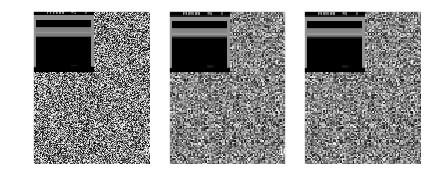

In [71]:
# Benchmarking resize ops
import timeit

img = np.random.rand(210, 160)
img[:84, :84] = cached_rb.buf[0].s[0, :, :]

pyplot.figure()
pyplot.subplot(1, 3, 1)
pyplot.tight_layout()
pyplot.imshow(img, cmap='gray')

import cv2
img_res_cv = cv2.resize(img, (84, 110), interpolation=cv2.INTER_LINEAR)
print(img_res_cv.shape)
pyplot.subplot(1, 3, 2)
pyplot.imshow(img_res_cv, cmap='gray')

import skimage
img_res = skimage.transform.resize(img, (110, 84), order=1, mode='constant')
print(img_res.shape)
pyplot.subplot(1, 3, 3)
pyplot.imshow(img_res, cmap='gray')

N = 1000

setup_str = 'import numpy as np, cv2, skimage; img = np.random.rand(210, 160)'
res_cv2 = timeit.timeit(
    'cv2.resize(img, (84, 110), interpolation=cv2.INTER_LINEAR)',
    setup_str, number=N)
res_ski = timeit.timeit(
    'skimage.transform.resize(img, (110, 84), order=1, mode="constant")',
    setup_str, number=N)
print(f'Benchmarking resize (N={N})\ncv2: {res_cv2}\nskimage: {res_ski}')

# Benchmarking RGB to YUV
img_rgb = np.random.rand(210, 160, 3)
#cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)

setup_str = '''
import numpy as np, cv2, skimage;
rgb = np.random.rand(210, 160, 3);
'''
rgb2y_code = timeit.timeit(
    '0.299 * rgb[:, :, 0] + 0.587 * rgb[:, :, 1] + 0.114 * rgb[:, :, 2]',
    setup_str, number=N)
rgb2y_ski = timeit.timeit('skimage.color.rgb2yuv(rgb)[:, :, 0]',
                          setup_str, number=N)
print(f'Benchmarking rgb to y(uv)\ncode: {rgb2y_code}\nskimage: {rgb2y_ski}')

In [83]:
# Trace step time.

def step():
  step = 0
  eps_rew = 0
  sars = env.step(exp.policy.get_action)
  rb.add(sars)
    
  experience_batch = rb.sample(BATCH_SIZE)
  m = exp.policy.update(experience_batch)
  
  eps_rew += sars.r
  if sars.s1 is None:
    m['r_per_eps'] = eps_rew
    eps_rew = 0

  for k, v in m.items():
    exp.plt.add_data(k, step, v)
    
t.runfunc(step)

 --- modulename: environment, funcname: step
1924.90 environment.py(137):     assert self.last_obs is not None
1924.90 environment.py(138):     ac = policy(np.expand_dims(self.last_obs, 0)).squeeze().astype(int)
 --- modulename: shape_base, funcname: expand_dims
1924.90 shape_base.py(314):     a = asarray(a)
 --- modulename: numeric, funcname: asarray
1924.90 numeric.py(492):     return array(a, dtype, copy=False, order=order)
1924.90 shape_base.py(315):     shape = a.shape
1924.90 shape_base.py(316):     if axis > a.ndim or axis < -a.ndim - 1:
1924.90 shape_base.py(322):     if axis < 0:
1924.90 shape_base.py(326):     return a.reshape(shape[:axis] + (1,) + shape[axis:])
 --- modulename: util, funcname: to_variable
1924.90 util.py(19):   if isinstance(x, np.ndarray):
1924.90 util.py(20):     x = th.from_numpy(x)
1924.90 util.py(21):   if dtype is not None:
1924.90 util.py(22):     x = x.type(dtype)
 --- modulename: _utils, funcname: _type
1924.90 _utils.py(20):     if new_type is None

 --- modulename: numeric, funcname: asanyarray
1925.10 numeric.py(544):     return array(a, dtype, copy=False, order=order, subok=True)
1925.10 shape_base.py(347):     arrays = [asanyarray(arr) for arr in arrays]
 --- modulename: numeric, funcname: asanyarray
1925.10 numeric.py(544):     return array(a, dtype, copy=False, order=order, subok=True)
1925.10 shape_base.py(347):     arrays = [asanyarray(arr) for arr in arrays]
 --- modulename: numeric, funcname: asanyarray
1925.10 numeric.py(544):     return array(a, dtype, copy=False, order=order, subok=True)
1925.10 shape_base.py(347):     arrays = [asanyarray(arr) for arr in arrays]
 --- modulename: numeric, funcname: asanyarray
1925.10 numeric.py(544):     return array(a, dtype, copy=False, order=order, subok=True)
1925.10 shape_base.py(347):     arrays = [asanyarray(arr) for arr in arrays]
 --- modulename: numeric, funcname: asanyarray
1925.10 numeric.py(544):     return array(a, dtype, copy=False, order=order, subok=True)
1925.10 shap

In [70]:
# Trace step time.
import trace
t = trace.Trace(timing=True)
t.runfunc(env.step, policy=exp.policy.get_action)

 --- modulename: environment, funcname: step
0.00 environment.py(138):     ac = policy(np.expand_dims(self.last_obs, 0)).squeeze().astype(int)
0.00 environment.py(139):     obs, r, done = self.step_k(ac, self.action_repeat, render)
 --- modulename: shape_base, funcname: expand_dims
0.00 shape_base.py(314):     a = asarray(a)
 --- modulename: numeric, funcname: asarray
0.00 numeric.py(492):     return array(a, dtype, copy=False, order=order)
0.00 shape_base.py(315):     shape = a.shape
0.00 shape_base.py(316):     if axis > a.ndim or axis < -a.ndim - 1:
0.00 shape_base.py(322):     if axis < 0:
0.00 shape_base.py(326):     return a.reshape(shape[:axis] + (1,) + shape[axis:])
 --- modulename: util, funcname: to_variable
0.00 util.py(19):   if isinstance(x, np.ndarray):
0.00 util.py(20):     x = th.from_numpy(x)
0.00 util.py(21):   if dtype is not None:
0.00 util.py(22):     x = x.type(dtype)
 --- modulename: _utils, funcname: _type
0.00 _utils.py(20):     if new_type is None:
0.00 _utils

SARS(s=array([[[0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        ...,
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275]],

       [[0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
        ...,
        [0.55686275, 0.55686275, 0.55686275, ..., 0.55686275,
         0.55686275, 0.55686275],
     